In [58]:
import numpy as np
import gym
import Portfolio_Gym
import A2C_V
import matplotlib.pyplot as plt
import tqdm 

In [2]:
# Testing out the ability of the Neural nets via standard supervised learning

In [69]:
%%time
# First collect a database of experiance acting randomly

Env = gym.make('Simulated-v0')
Env.Set_Params(Mu = 0.0562, Sigma = 0.163, Row = 1, Rf = 0.036, Max_Leverage  = 10, Min_Leverage  = -10,
               Time_Horizon  = 1,  Time_Step = 1/12, Risk_Aversion = 0.9, State_Corrolations  = [0.2, -0.5],
               Intermediate_Reward = False)

Exp = []
for _ in range(50000):
    State_0 = Env.reset()
    Done = False
    Episode_Exp = []
    while Done == False:
        State_1, Reward, Done, Info = Env.step(Env.action_space.sample())
        Episode_Exp.append({'s0' : State_0, 's1' : State_1, 'r' : Reward})
        State_0 = State_1
    
    # Now that the episode is finished, backpropergate the reward across the episode in the 
    # Monte Carlo fashion
    for i in range(len(Episode_Exp) - 1)[::-1]:
        Episode_Exp[i]['r'] += Episode_Exp[i+1]['r'] * 0.999
    Exp.extend(Episode_Exp)

len(Exp)

CPU times: user 2min 24s, sys: 1.39 s, total: 2min 26s
Wall time: 2min 25s


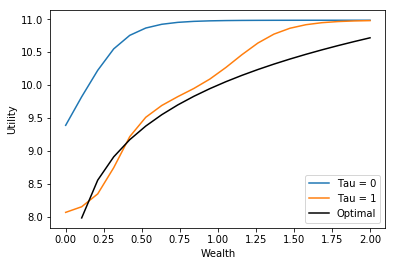

In [70]:
Epoch      = 15
Batch_Size = 24

Critic_Network = A2C_V.Critic_NeuralNet([4,4], 4, 1, Learning_Rate = 0.075, Activation = 'Relu', Epoch = 1)

State = np.array([e['s0'] for e in Exp]).reshape(-1,4)
Value = np.array([e['r']  for e in Exp]).reshape(-1,1)

for i in range(Epoch):
    idx = np.random.choice(State.shape[0], size = (State.shape[0] // Batch_Size, Batch_Size), replace = False)
    for i in range(idx.shape[0]):
        Critic_Network.Fit(State[idx[i]], Value[idx[i]])

# Now construct plots of the results
State = np.zeros((20,4))
State[:,0] = np.linspace(0,2,20)
Output = Critic_Network.Predict(State).flatten()
State[:,1] = 1
# State[:,-1] = 1
Output3 = Critic_Network.Predict(State).flatten()
Output2 = (np.linspace(0,2,20) ** (1 - 0.9)) / (1 - 0.9)
Output2[0] = None

X = np.linspace(0,2,20)
plt.plot(X, Output, label = "Tau = 0")
plt.plot(X, Output3, label = 'Tau = 1')
plt.plot(X, Output2, label = 'Optimal', color = 'k')
plt.xlabel('Wealth')
plt.ylabel('Utility')
plt.legend()
plt.show()




In [30]:
# # Generate some pseudo experiance
# Epoch      = 15
# Batch_Size = 1200

# Critic_Network = A2C_V.Critic_NeuralNet([16,8,4], 4, 1, Learning_Rate = 0.075, Activation = 'Sigmoid', Epoch = 1)

# # Exp = np.clip(np.random.normal(1,0.25, size = (500000, 2)), 0.25, 1.75)
# Exp = np.random.uniform(0.1, 2, size = (500000, 5))
# Exp[:,-1] = Env.Utility(Exp[:,0])

# State = Exp[:,:4].reshape(-1,4)
# Value = Exp[:,4].reshape(-1,1)

# for i in range(Epoch):
#     idx = np.random.choice(State.shape[0], size = (State.shape[0] // Batch_Size, Batch_Size), replace = False)
#     for i in range(idx.shape[0]):
#         Critic_Network.Fit(State[idx[i]], Value[idx[i]])

# # Now construct plots of the results
# State = np.zeros((20,4))
# State[:,0] = np.linspace(0,2,20)
# Output = Critic_Network.Predict(State).flatten()
# State[:,-1] = 1
# Output3 = Critic_Network.Predict(State).flatten()
# Output2 = (np.linspace(0,2,20) ** (1 - 0.9)) / (1 - 0.9)
# Output2[0] = None

# X = np.linspace(0,2,20)
# plt.plot(X, Output, label = 'Network')
# plt.plot(X, Output3, label = 'Network, 1')
# plt.plot(X, Output2, label = 'Optimal', color = 'k')
# plt.x_label = 'Wealth'
# plt.y_label = 'Utility'
# plt.legend()
# plt.show()


100%|██████████| 500000/500000 [04:53<00:00, 1705.34it/s]


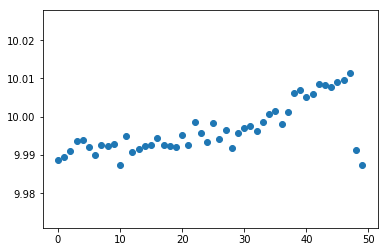

In [59]:
# Next we seek to test the performance of the actor using 'clean' data

Retrain_Freq = 60
Sigma        = 3

'''
Method:
    1. Wealth will be randomly initialised
    2. An action will be randomly taken, ending the episode
    3. Advantage will be determined as terminal utility minus the utility of the initial state
'''

Env = gym.make('Simulated-v0')
Env.Set_Params(Mu = 0.0562, Sigma = 0.163, Row = 1, Rf = 0.036, Max_Leverage  = 100, Min_Leverage  = -100,
               Time_Horizon  = 1/12,  Time_Step = 1/12, Risk_Aversion = 0.9, State_Corrolations  = [0.2, -0.5],
               Intermediate_Reward = False)

Actor = A2C_V.Policy_NeuralNet([8,8], 4, 1, Learning_Rate = 0.025, Epoch = 1)

Exp = []
Terminal_Util = []
for i in tqdm.tqdm(range(500000)):
    
    State_0 = Env.reset()
    Action = np.clip(np.random.normal(Actor.Predict(State_0.reshape(1, -1)).flatten(), Sigma), -100, 100)
    State_1, Reward, Done, Info = Env.step(Action)
    Advantage = Reward - Env.Utility(State_0[0])
    Exp.append({'s0' : State_0, 's1' : State_1, 'a' : Action, 'r' : Reward, 'Adv' : Advantage})
    Terminal_Util.append(Env.Utility(State_1[0] / State_0[0]))
    
    if i % Retrain_Freq == 0:
        State  = np.array([e['s0'] for e in Exp]).reshape(-1,4)
        Action = np.array([e['a'] for e in Exp]).reshape(-1,1)
        Adv    = np.array([e['Adv']  for e in Exp]).reshape(-1,1)
        
        Actor.Fit(State, Action, Adv, Sigma)
        Exp = []
 
Terminal_Util = [np.mean(Terminal_Util[i*10000 : (i+1)*10000]) for i in range(int(len(Terminal_Util) / 1000))]

plt.scatter(np.arange(len(Terminal_Util)), Terminal_Util)
plt.show()



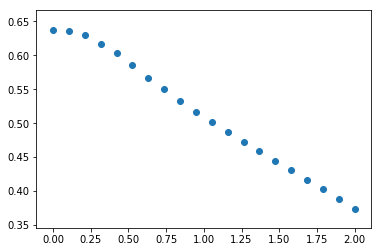

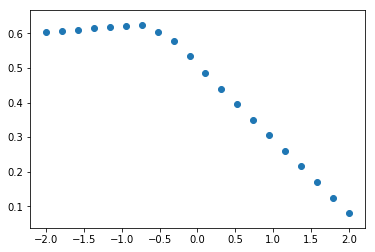

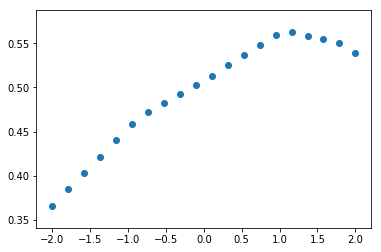

In [60]:
# Finally we may construct some plots of the sensitivities of the actor to wealth and the factors

def Plot_Sensitivity(N):
    State = np.zeros((20,4))
    State[:,0] = 1
    
    if N == 0:
        X = np.linspace(0,2,20)
        State[:,N] = X
    else:
        X = np.linspace(-2,2,20)
        State[:,N] = X
    
    plt.scatter(X, Actor.Predict(State).flatten())
    plt.show()

Plot_Sensitivity(0)
Plot_Sensitivity(2)
Plot_Sensitivity(3)


100%|██████████| 50000/50000 [03:05<00:00, 279.56it/s]


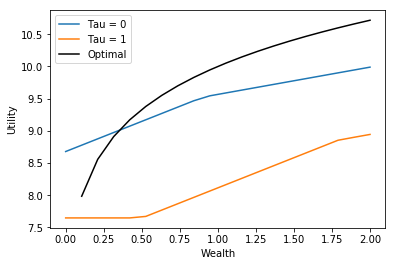

In [72]:
'''Advanced critic analysis, now implmented using bellman eqaution and online learning'''

Retrain_Freq = 24

'''
Method:
    1. Wealth will be randomly initialised
    2. An action will be randomly taken, ending the episode
    3. Advantage will be determined as terminal utility minus the utility of the initial state
'''

Env = gym.make('Simulated-v0')
Env.Set_Params(Mu = 0.0562, Sigma = 0.163, Row = 1, Rf = 0.036, Max_Leverage  = 10, Min_Leverage  = -10,
               Time_Horizon  = 1,  Time_Step = 1/12, Risk_Aversion = 0.9, State_Corrolations  = [0.2, -0.5],
               Intermediate_Reward = False)

Critic_Network = A2C_V.Critic_NeuralNet([4,4], 4, 1, Learning_Rate = 0.075, Activation = 'Relu', Epoch = 1)

Exp = []
for i in tqdm.tqdm(range(50000)):
    
    State_0 = Env.reset()
    Done = False
    while Done == False:
        State_1, Reward, Done, Info = Env.step(Env.action_space.sample())
        Exp.append({'s0' : State_0, 's1' : State_1, 'r' : Reward, 'd' : Done})
        State_0 = State_1
        
    if i % Retrain_Freq == 0:
        State   = np.array([e['s0'] for e in Exp]).reshape(-1,4)
        State_1 = np.array([e['s1'] for e in Exp]).reshape(-1,4)
        Value   = Critic_Network.Predict(State_1).flatten()
        Value   = np.array([Value[i] * 0.99 * (1 - Exp[i]['d']) + Exp[i]['r'] for i in range(len(Exp))]).reshape(-1,1)
        
        Critic_Network.Fit(State, Value)
        Exp = []
 
# Now construct plots of the results
State = np.zeros((20,4))
State[:,0] = np.linspace(0,2,20)
Output = Critic_Network.Predict(State).flatten()
State[:,1] = 1
# State[:,-1] = 1
Output3 = Critic_Network.Predict(State).flatten()
Output2 = (np.linspace(0,2,20) ** (1 - 0.9)) / (1 - 0.9)
Output2[0] = None

X = np.linspace(0,2,20)
plt.plot(X, Output, label  = "Tau = 0")
plt.plot(X, Output3, label = 'Tau = 1')
plt.plot(X, Output2, label = 'Optimal', color = 'k')
plt.xlabel('Wealth')
plt.ylabel('Utility')
plt.legend()
plt.show()
